In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from pathlib import Path
#import geopandas as gpd

import os
import requests, zipfile, io
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# df1 = pd.read_csv('C:/Users/lsd92/Codes/capstone/csv_data/detected_1.csv')
# df2 = pd.read_csv('C:/Users/lsd92/Codes/capstone/csv_data/detected_2.csv')
# df3 = pd.read_csv('C:/Users/lsd92/Codes/capstone/csv_data/detected_3.csv')
# pdList = [df1, df2, df3]  # List of your dataframes
# df = pd.concat(pdList)
# #df.head()
# df

csv_path = Path("C:/Users/lsd92/Codes/capstone/csv_data/out.csv")
df = pd.read_csv(csv_path)
df.head()

,Unnamed: 0,time,latitude,longitude,speed,original_file,image_file,obj_class_name,obj_class,x,y,w,h,confidences,date,month,day of week
0,2,2021-10-04 14:16:03,37.866789,122.254125,17.7027,GRMN_Bancroft_0.MP4,GRMN_Bancroft_0_171.jpg,bus,1,0.021615,0.433333,0.043229,0.235185,0.688805,2021-10-04 14:16:03,10,0
1,4,2021-10-04 14:16:05,37.866919,122.254153,20.9214,GRMN_Bancroft_0.MP4,GRMN_Bancroft_0_218.jpg,bus,1,0.032292,0.405093,0.021875,0.047222,0.539737,2021-10-04 14:16:05,10,0
2,10,2021-10-04 14:16:58,37.869214,122.254575,9.6560,GRMN_Bancroft_1.MP4,GRMN_Bancroft_1_17.jpg,ups_truck,5,0.513542,0.602778,0.077083,0.151852,0.529567,2021-10-04 14:16:58,10,0
3,11,2021-10-04 14:16:58,37.869214,122.254575,9.6560,GRMN_Bancroft_1.MP4,GRMN_Bancroft_1_18.jpg,ups_truck,5,0.515365,0.603241,0.072396,0.150926,0.617564,2021-10-04 14:16:58,10,0
4,13,2021-10-04 14:16:58,37.869214,122.254575,9.6560,GRMN_Bancroft_1.MP4,GRMN_Bancroft_1_25.jpg,ups_truck,5,0.528125,0.600463,0.083333,0.149074,0.670175,2021-10-04 14:16:58,10,0


In [3]:
df['time'] = pd.to_datetime(df['time'])
df = df[df['confidences']>=0.85]
df= df[df['latitude'] < 180]
df= df[df['longitude'] < 180]
df['longitude'] = df['longitude']*-1
#df = df[df["obj_class_name"].str.contains("bus")==False]
df['box area'] = df['w'] * df['h'] 
df.head()

,Unnamed: 0,time,latitude,longitude,speed,original_file,image_file,obj_class_name,obj_class,x,y,w,h,confidences,date,month,day of week,box area
46,84,2021-10-04 14:17:13,37.869236,-122.255339,19.3121,GRMN_Bancroft_1.MP4,GRMN_Bancroft_1_461.jpg,fedex_truck,4,0.635938,0.623611,0.092708,0.134259,0.879880,2021-10-04 14:17:13,10,0,0.012447
47,85,2021-10-04 14:17:13,37.869236,-122.255339,19.3121,GRMN_Bancroft_1.MP4,GRMN_Bancroft_1_462.jpg,fedex_truck,4,0.638802,0.624537,0.091146,0.132407,0.880430,2021-10-04 14:17:13,10,0,0.012068
48,86,2021-10-04 14:17:13,37.869236,-122.255339,19.3121,GRMN_Bancroft_1.MP4,GRMN_Bancroft_1_463.jpg,fedex_truck,4,0.640365,0.625463,0.090104,0.130556,0.878385,2021-10-04 14:17:13,10,0,0.011764
50,88,2021-10-04 14:17:13,37.869236,-122.255339,19.3121,GRMN_Bancroft_1.MP4,GRMN_Bancroft_1_465.jpg,fedex_truck,4,0.641406,0.627315,0.096354,0.139815,0.866673,2021-10-04 14:17:13,10,0,0.013472
62,103,2021-10-04 14:17:13,37.869236,-122.255339,19.3121,GRMN_Bancroft_1.MP4,GRMN_Bancroft_1_477.jpg,fedex_truck,4,0.663281,0.634259,0.114063,0.164815,0.907289,2021-10-04 14:17:13,10,0,0.018799


In [4]:
# remove duplicate
df = df.loc[df.groupby(['time', 'original_file', "obj_class_name"])['box area'].idxmax()]


# remove zero speed
df = df[df['speed'] != 0]

# # speed unit from km/h to m/s
# df['speed_mps'] = df['speed']/3.6

# # normalize count
# # Assume that the camera can see up to 20 meters
# # in GRMN_Bancroft_48.MP4 there are 4 second contains fedex and the speed is 20 km/h
# # 4* (20/3.6) = 20 
# #df[df['original_file'] == 'GRMN_Bancroft_48.MP4']
# #print(df[df['obj_class_name'] == 'fedex_truck']['original_file'])
# max_seen = 20
# df['normalized_count'] = df['speed_mps']/max_seen


#df.to_csv('filtered_out.csv') 

In [5]:
df['should_keep'] = False

## remove duplicate
splits = list(df.groupby(["original_file", "obj_class_name"]))
results = []

for split in splits:
    frame = split[1]
    n = frame.shape[0]
    i = 0
    while i < n:
        current = frame.iloc[i]
        if i + 1 < n:
            next = frame.iloc[i + 1]
            if (pd.Timedelta(next['time'] - current['time']).seconds) > 3:
                frame.iloc[i, df.columns.get_loc('should_keep')] = True
        else:
            frame.iloc[i, df.columns.get_loc('should_keep')] = True
        
        i += 1
    frame = frame[frame['should_keep'] == True]
    results.append(frame)


df = pd.concat(results)
        

df

,Unnamed: 0,time,latitude,longitude,speed,original_file,image_file,obj_class_name,obj_class,x,y,w,h,confidences,date,month,day of week,box area,should_keep
76,118,2021-10-04 14:17:14,37.869228,-122.255411,20.9214,GRMN_Bancroft_1.MP4,GRMN_Bancroft_1_492.jpg,fedex_truck,4,0.700000,0.645833,0.146875,0.217593,0.867439,2021-10-04 14:17:14,10,0,0.031959,True
134,236,2021-10-04 14:17:25,37.869117,-122.256217,20.9214,GRMN_Bancroft_1.MP4,GRMN_Bancroft_1_827.jpg,fedex_truck,4,0.832812,0.687500,0.334375,0.452778,0.862031,2021-10-04 14:17:25,10,0,0.151398,True
1958,2629,2021-11-15 16:25:17,37.868503,-122.260597,11.2654,GRMN_Bancroft_1002.MP4,GRMN_Bancroft_1002_631.jpg,bus,1,0.916927,0.526852,0.161979,0.766667,0.878205,2021-11-15 16:25:17,11,0,0.124184,True
2021,2760,2021-11-15 16:25:26,37.868431,-122.261094,24.1401,GRMN_Bancroft_1002.MP4,GRMN_Bancroft_1002_900.jpg,fedex_truck,4,0.082813,0.485648,0.165625,0.476852,0.897188,2021-11-15 16:25:26,11,0,0.078979,True
2501,4811,2021-11-15 16:52:56,37.868567,-122.260672,22.5308,GRMN_Bancroft_1008.MP4,GRMN_Bancroft_1008_1777.jpg,amazon_truck,6,0.868229,0.483333,0.263542,0.307407,0.856841,2021-11-15 16:52:56,11,0,0.081015,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544324,705622,2021-11-15 15:52:50,37.868494,-122.261072,12.8747,GRMN_Bancroft_994.MP4,GRMN_Bancroft_994_1685.jpg,fedex_truck,4,0.084635,0.483796,0.169271,0.475000,0.900096,2021-11-15 15:52:50,11,0,0.080404,True
1544303,705560,2021-11-15 15:52:42,37.868539,-122.260669,17.7027,GRMN_Bancroft_994.MP4,GRMN_Bancroft_994_1440.jpg,ups_truck,5,0.347135,0.438426,0.084896,0.163889,0.851334,2021-11-15 15:52:42,11,0,0.013913,True
1544788,706311,2021-11-15 16:19:25,37.867111,-122.254083,17.7027,GRMN_Bancroft_996.MP4,GRMN_Bancroft_996_888.jpg,bus,1,0.401823,0.442593,0.040104,0.085185,0.858605,2021-11-15 16:19:25,11,0,0.003416,True
1545035,706598,2021-11-15 16:20:19,37.869236,-122.254972,16.0934,GRMN_Bancroft_997.MP4,GRMN_Bancroft_997_690.jpg,bus,1,0.820312,0.521296,0.359375,0.748148,0.873917,2021-11-15 16:20:19,11,0,0.268866,True


In [6]:
df.to_csv('filtered_out.csv') 

In [7]:
df['obj_class_name'].value_counts()

bus             2114
fedex_truck      621
amazon_truck     475
ups_truck        217
Name: obj_class_name, dtype: int64

In [8]:
# add date week and hour infor
date = pd.to_datetime(df['time']).dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
df['year'] = date.dt.year
df['month'] = date.dt.month
df['day'] = date.dt.day
df['weekday'] = date.dt.weekday + 1
df['hour'] = date.dt.hour
df['date'] = date.dt.date
#df[['date', 'normalized_count', 'obj_class_name']].groupby(['date', 'obj_class_name']).count()


,date,obj_class_name,count
0,2021-10-04,amazon_truck,7
1,2021-10-04,bus,95
2,2021-10-04,fedex_truck,47
3,2021-10-04,ups_truck,17
4,2021-10-05,bus,15
...,...,...,...
106,2021-12-14,ups_truck,7
107,2021-12-15,amazon_truck,7
108,2021-12-15,bus,43
109,2021-12-15,fedex_truck,12


Text(0.5, 1.0, 'Average count of different types of vehicles seen per day')

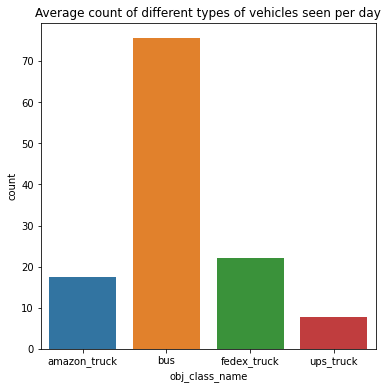

In [9]:
count = df[['date', 'obj_class_name', 'should_keep']].groupby(['date', 'obj_class_name']).count().reset_index().rename(columns={'should_keep':'count'})
display(count)

plt.figure(figsize=(6, 6))

sns.barplot(x="obj_class_name", y="count", data=count.groupby('obj_class_name').mean().reset_index(), capsize=.2)
plt.title('Average count of different types of vehicles seen per day')

In [10]:
# display(df['latitude'].value_counts())
# display(df['longitude'].value_counts())

Text(0.5, 1.0, 'Hourly distribution of different types of vehicles')

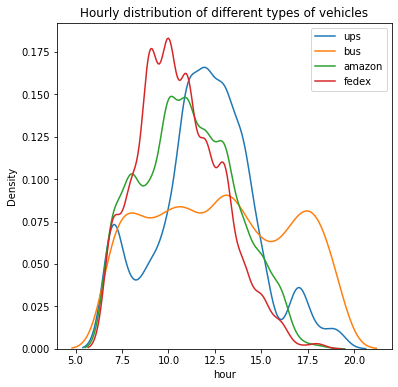

In [11]:
plt.figure(figsize=(6, 6))
ups = df[['hour', 'obj_class_name']].query("obj_class_name == 'ups_truck'")
bus = df[['hour', 'obj_class_name']].query("obj_class_name == 'bus'")
amazon = df[['hour', 'obj_class_name']].query("obj_class_name == 'amazon_truck'")
fedex = df[['hour', 'obj_class_name']].query("obj_class_name == 'fedex_truck'")

bins = [i for i in range(6,20)]
kde_kws = {"bw": 0.2}

sns.kdeplot(data = ups['hour'], bw=0.2, label='ups')
sns.kdeplot(data = bus['hour'], bw=0.2, label='bus')
sns.kdeplot(data = amazon['hour'], bw=0.2, label='amazon')
sns.kdeplot(data = fedex['hour'], bw=0.2, label='fedex')
plt.legend();
plt.title('Hourly distribution of different types of vehicles')

<AxesSubplot:xlabel='hour', ylabel='Density'>

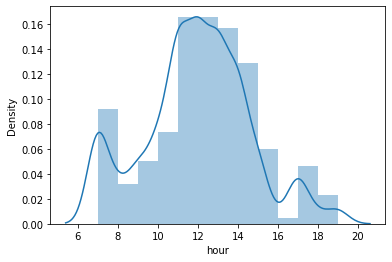

In [12]:
sns.distplot(ups['hour'], bins=bins, kde=True, kde_kws=kde_kws, label='ups')

<AxesSubplot:xlabel='hour', ylabel='Density'>

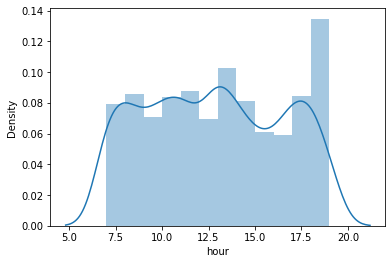

In [13]:
sns.distplot(bus['hour'], bins=bins, kde=True, kde_kws=kde_kws, label='bus')

<AxesSubplot:xlabel='hour', ylabel='Density'>

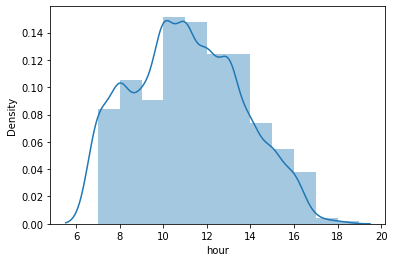

In [14]:
sns.distplot(amazon['hour'], bins=bins, kde=True, kde_kws=kde_kws, label='amazon')

<AxesSubplot:xlabel='hour', ylabel='Density'>

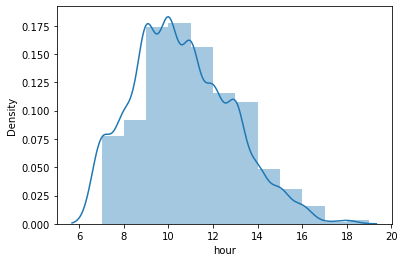

In [15]:
sns.distplot(fedex['hour'], bins=bins, kde=True, kde_kws=kde_kws, label='fedex')

Text(0.5, 1.0, 'Weekday distribution of different types of vehicles')

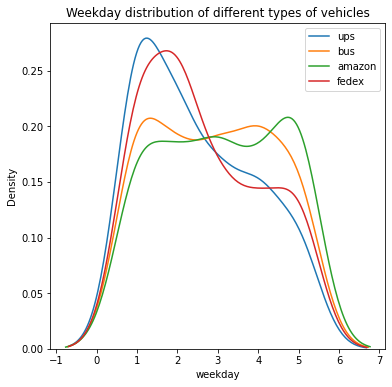

In [16]:
plt.figure(figsize=(6, 6))
ups = df[['weekday', 'obj_class_name']].query("obj_class_name == 'ups_truck'")
bus = df[['weekday', 'obj_class_name']].query("obj_class_name == 'bus'")
amazon = df[['weekday', 'obj_class_name']].query("obj_class_name == 'amazon_truck'")
fedex = df[['weekday', 'obj_class_name']].query("obj_class_name == 'fedex_truck'")


sns.kdeplot(data = ups['weekday'], bw=0.4, label='ups')
sns.kdeplot(data = bus['weekday'], bw=0.4, label='bus')
sns.kdeplot(data = amazon['weekday'], bw=0.4, label='amazon')
sns.kdeplot(data = fedex['weekday'], bw=0.4, label='fedex')
plt.legend();
plt.title('Weekday distribution of different types of vehicles')

Text(0.5, 1.0, 'Longitude distribution of different types of vehicles')

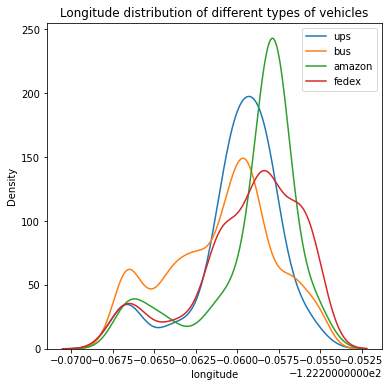

In [17]:
plt.figure(figsize=(6, 6))
l_filter = df[df['longitude'] <= -122.255]
ups = l_filter[['longitude', 'obj_class_name']].query("obj_class_name == 'ups_truck'")
bus = l_filter[['longitude', 'obj_class_name']].query("obj_class_name == 'bus'")
amazon = l_filter[['longitude', 'obj_class_name']].query("obj_class_name == 'amazon_truck'")
fedex = l_filter[['longitude', 'obj_class_name']].query("obj_class_name == 'fedex_truck'")

sns.kdeplot(data = ups['longitude'],  label='ups')
sns.kdeplot(data = bus['longitude'],  label='bus')
sns.kdeplot(data = amazon['longitude'],  label='amazon')
sns.kdeplot(data = fedex['longitude'],  label='fedex')
plt.legend();
plt.title('Longitude distribution of different types of vehicles')